<a href="https://colab.research.google.com/github/pepborrell/LauzHack2019/blob/master/PredictCommentMarkov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add, Concatenate, TimeDistributed
import tensorflow.keras.preprocessing.image as image
import tensorflow.keras.preprocessing.sequence as sequence
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3

# Predicting the comment
From an image, we want to predict a comment.

## Loading the data

In [0]:
#url = 'https://pastebin.com/raw/SjMqw5Wx'
# url = 'https://pastebin.com/raw/Kbr3apyg'
# url = 'https://pastebin.com/raw/r2E7KsWP'
url = 'https://pastebin.com/raw/LDU9XZpU'
df = pd.read_csv(url)

df.head()

,id,postid,url,upvotes,top comment
0,0,dpoppg,https://i.redd.it/v91swki75wv31.jpg,125639,['Ah\\ yes\\ the\\ I\\̓\\̉\\̓\\̆\\͗\\̭\\͇\\͙\\...
1,1,dikhsj,https://i.redd.it/osr5o5ox5us31.jpg,105442,"['As\\ an\\ Italian\\,\\ I\\ 100\\%\\ relate',..."
2,2,ds0ttz,https://i.redd.it/p9a9mskj0ww31.jpg,65,"['That\\'s\\ my\\ master\\ plan', 'OP\\ really..."
3,3,dgcuf8,https://i.redd.it/flsim843wvr31.jpg,138513,['What\\'s\\ the\\ difference\\ between\\ 1\\ ...
4,4,dplvla,https://i.redd.it/4j8thq1lyuv31.jpg,35836,"['F', '\\⠀\\⠀\\⢀\\⡤\\⢶\\⣶\\⣶\\⡄\\⠀\\⠀\\⠀\\⠀\\⠀..."


## Text cleaning and preprocessing


In [7]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
st_words = set(stopwords.words('english'))

def cleanWords(text):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    # Convert to lowercase
    text = [word.lower() for word in text]
    # remove punctuation from each token
    text = [word.translate(table) for word in text]
    # remove hanging 's' and 'a'
    text = [word for word in text if len(word)>1 or word in ['i', 'u']]
    # remove tokens with numbers in them
    text = [word for word in text if not word.isnumeric()]
    # remove stopwords
    # text = [word for word in text if not word in st_words]
    # remove forbidden words
    forbidden_words = []
    text = [word for word in text if word not in forbidden_words]
    return text

def cleanComment(text):
    text = text.split(' ')
    text = cleanWords(text)
    return text

def addStartEndSeq(words):
    return ['startseq'] + words + ['endseq']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
df['clean_comment'] = df.apply(lambda x : cleanComment(x['top comment']), axis=1)

df['clean_comment'] = df.apply(lambda x : addStartEndSeq(x['clean_comment']), axis=1)

max_comment_length = max(len(x) for x in df['clean_comment'])
max_comment_length = 30

df_copy = df
df = df[df['clean_comment'].apply(lambda x : len(x) >= 3)]
df = df[df['clean_comment'].apply(lambda x : len(x) <= max_comment_length)]

all_text = []
for text in df['clean_comment']:
    all_text += text

from collections import Counter
counter = Counter(all_text)
word_freq = list(counter.items())
word_freq.sort(key = (lambda x : -x[1]))
word_freq = ['PAD'] + word_freq

# To check where are word frequencies change
# for idx, elem in enumerate(word_freq):
#     if elem[1] == 2:
#         print(idx)
#         break

(array([ 0., 13., 40., 45., 56., 39., 47., 33., 23.,  0.]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ]),
 <a list of 10 Patch objects>)

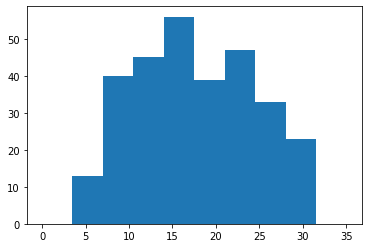

In [0]:
import matplotlib.pyplot as plt
sizes = [len(x) for x in df['clean_comment']]
plt.hist(sizes, range=(0,35))

In [0]:
print(word_freq)

['PAD', ('startseq', 296), ('endseq', 296), ('the', 157), ('i', 144), ('you', 92), ('is', 87), ('to', 63), ('it', 59), ('this', 55), ('that', 55), ('of', 48), ('and', 42), ('no', 42), ('what', 36), ('not', 36), ('in', 36), ('just', 34), ('was', 30), ('my', 29), ('for', 29), ('me', 27), ('but', 27), ('on', 27), ('im', 26), ('are', 26), ('be', 26), ('ok', 23), ('its', 23), ('so', 21), ('like', 20), ('dont', 20), ('can', 19), ('how', 19), ('at', 17), ('here', 17), ('boomer', 17), ('we', 17), ('yes', 16), ('have', 16), ('your', 16), ('know', 16), ('only', 16), ('who', 15), ('all', 15), ('or', 15), ('thats', 14), ('one', 14), ('good', 14), ('too', 14), ('nice', 14), ('he', 14), ('oh', 14), ('an', 13), ('i’m', 13), ('if', 13), ('with', 13), ('now', 12), ('yeah', 12), ('do', 12), ('will', 12), ('from', 11), ('then', 11), ('meme', 11), ('thanks', 11), ('because', 11), ('see', 11), ('right', 11), ('it’s', 11), ('fuck', 11), ('got', 10), ('about', 10), ('happy', 10), ('day', 10), ('joe', 10), ('

In [0]:
import requests
response = requests.get('https://raw.githubusercontent.com/coblezc/drake-ebook/master/drake-lyrics.txt')
all_text = cleanComment(response.text)

In [0]:
all_text = "Somebody once told me the world is gonna roll me I ain't the sharpest tool in the shed She was looking kind of dumb with her finger and her thumb In the shape of an L on her forehead Well, the years start coming and they don't stop coming Fed to the rules and I hit the ground running Didn't make sense not to live for fun Your brain gets smart but your head gets dumb So much to do, so much to see So what's wrong with taking the back streets? You'll never know if you don't go You'll never shine if you don't glow Hey, now, you're an All Star, get your game on, go play Hey, now, you're a Rock Star, get the show on, get paid And all that glitters is gold Only shooting stars break the mold It's a cool place and they say it gets colder You're bundled up now wait 'til you get older But the meteor men beg to differ Judging by the hole in the satellite picture The ice we skate is getting pretty thin The water's getting warm so you might as well swim My world's on fire. How about yours? That's the way I like it and I'll never get bored. [Chorus 2x] Somebody once asked could I spare some change for gas I need to get myself away from this place I said yep, what a concept I could use a little fuel myself And we could all use a little change Well, the years start coming and they don't stop coming Fed to the rules and I hit the ground running Didn't make sense not to live for fun Your brain gets smart but your head gets dumb So much to do so much to see So what's wrong with taking the back streets You'll never know if you don't go You'll never shine if you don't glow. [Chorus] And all that glitters is gold Only shooting stars break the mold"

all_text = cleanComment(all_text)

In [0]:
import random

def review_generator(first_word, all_text):
    # text = ' '.join([i for i in text if not i.isdigit()]).replace("\n", " ").split(' ')
    
    text = all_text

    index = 1
    chain = {}
    text_size = 30
    
    for word in text[1:]:
        key = text[index-1]
        if key in chain:
            chain[key].append(word)
        else:
            chain[key] = [word]
        index += 1
    
    # word1 = random.choice(list(chain.keys()))
    word1 = first_word
    message = word1.capitalize()

    while len(message.split(' ')) < text_size and message.split(' ')[-1] != 'endseq':
        word2 = random.choice(chain[word1])
        word1 = word2
        message += ' ' + word2
    return ' '.join(message.split()[:-1])

In [53]:
review_generator('gold', all_text)

'Gold gettin hot beats still regina hall and no chorus we keep us nah ovo unruly one shot for the present and light up wait until the floor with some extra late at us two'